In [1]:
import os
import json
import data_parser
import matplotlib.pyplot as plt
import numpy as np
import CoreLocation
import evaluation

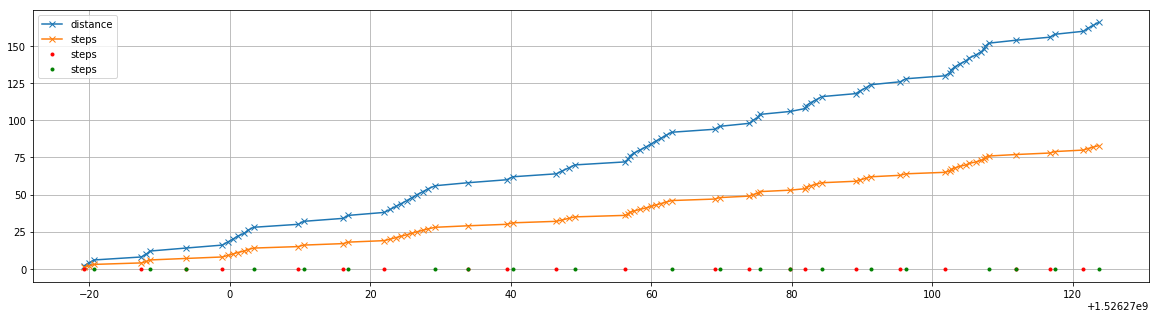

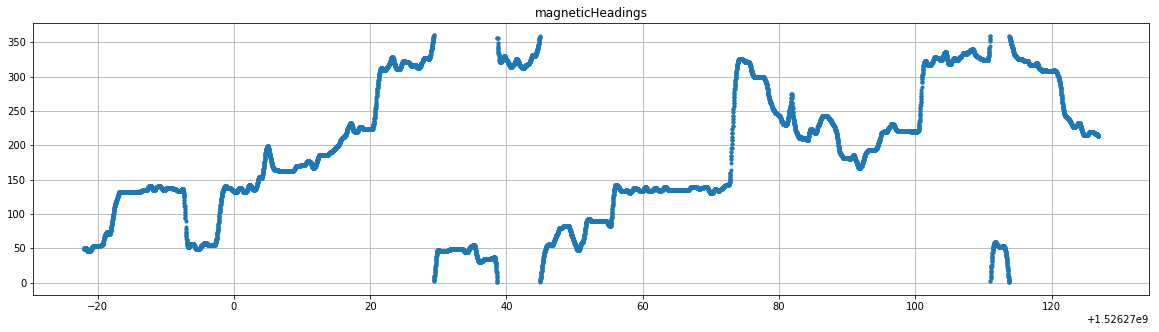

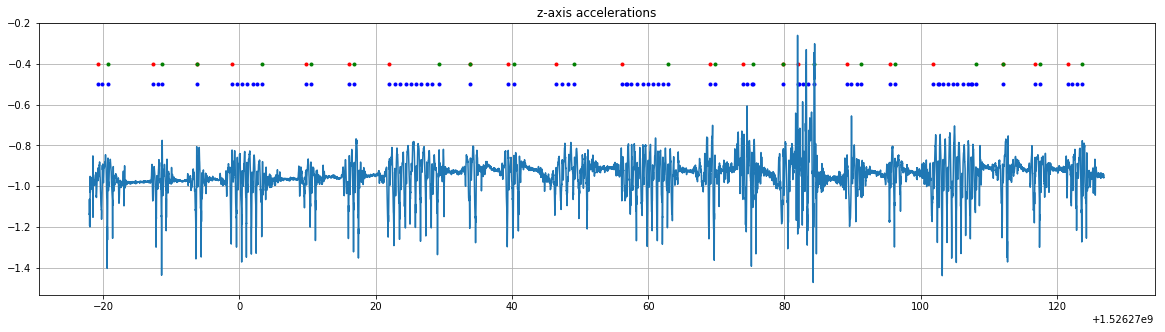

In [15]:
data_label = "cattalyya-13-stop"
axis = 'z'
# cattalyya-13-stop 1526269978
# cattalyya-13-vertical 1526269430
_, acc_data = data_parser.load_data_all(data_label, start_after_time=1526269978)
    
acc_timestamps = []
magneticHeadings = []
accelerations = []
for entry in acc_data:
    acc_timestamps.append(entry.timestamp)
    magneticHeadings.append(entry.magneticHeading)
    if axis == 'z':
        accelerations.append(entry.zAcceleration)
    elif axis == 'y':
        accelerations.append(entry.yAcceleration)

begin_timestamp = acc_timestamps[0]

ped_timestamps = []
steps = []
distances = []
# for entry in ped_data:
#     ped_timestamps.append(entry.timestamp)
#     steps.append(entry.steps)
#     distances.append(entry.distanceTraveled)
    
step_count, ped_timestamps, steps, distances, walking_timestamps = data_parser.steps_count(acc_data, axis=axis)    

plt.figure(figsize=(20,5))
plt.plot(ped_timestamps, map(lambda x: x/12., distances), 'x-', label="distance")
plt.plot(ped_timestamps, steps, 'x-', label="steps")
plt.plot([intval[0] for intval in walking_timestamps], [-.4]*len(walking_timestamps), 'r.', label="steps")
plt.plot([intval[1] for intval in walking_timestamps], [-.4]*len(walking_timestamps), 'g.', label="steps")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(20,5))
plt.plot(acc_timestamps, magneticHeadings, '.')
plt.grid()
plt.title("magneticHeadings")
plt.show()

plt.figure(figsize=(20,5))
plt.plot([intval[0] for intval in walking_timestamps], [-.4]*len(walking_timestamps), 'r.', label="steps")
plt.plot([intval[1] for intval in walking_timestamps], [-.4]*len(walking_timestamps), 'g.', label="steps")
plt.plot(ped_timestamps, [-.5]*len(ped_timestamps), 'b.')
plt.plot(acc_timestamps, accelerations, '-')
plt.grid()
plt.title("%s-axis accelerations" % axis)
plt.show()

In [3]:
room = CoreLocation.Room.import_room_data('room_measurement.json', "G5-may13")
x, y = room.initial_location.coord
loc = CoreLocation.Locations()
# begin_heading = acc_data[0].magneticHeading
begin_heading = 50 # depend on the room; have not actually measured

for i, entry in enumerate(acc_data[:-1]):
    timestamp = entry.timestamp
    heading = entry.magneticHeading
    relative_heading = heading - begin_heading

    heading_radian = np.deg2rad(relative_heading)
    
    speed = data_parser.speed_at_timestamp(ped_timestamps, distances, walking_timestamps, timestamp)
#     speed = 1
    if speed is None:
        continue
    elapsed_time = acc_data[i + 1].timestamp - timestamp
    distance = speed * elapsed_time
    dx = distance * np.cos(heading_radian)
    dy = distance * np.sin(heading_radian)
    x += dx
    y += dy
    loc.add_np_point((x, y), timestamp)
    

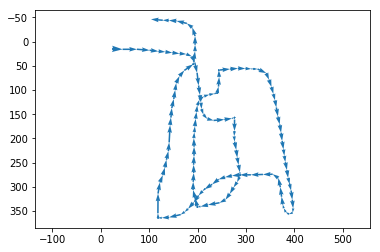

In [4]:
ax = loc.visualize(downsample=50)
ax.axis('equal')
plt.gca().invert_yaxis()
plt.show()

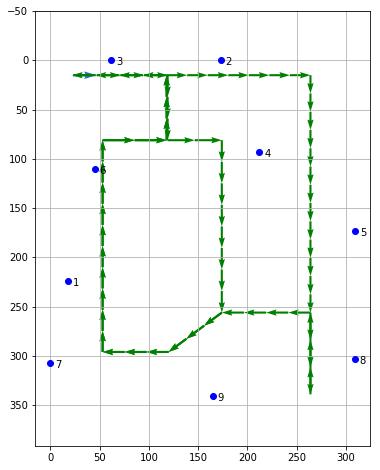

In [5]:
room.visualize_with_groundtruth(loc, translate_init_loc=True, translate=(0, 0), downsample=50)

In [6]:
loc_errors, times = evaluation.evaluate(loc, room.step_landmarks)

(23.42803247593258, 15.001973898486446) (23, 15)
(70.94759365642317, 15.606245755334838) (47.0, 15.0)
(115.09123546482604, 19.692490227004114) (71.0, 15.0)
(142.34345612918358, 22.35352177884006) (95.0, 15.0)
(170.69583850971338, 25.361159378741455) (119.0, 15.0)
(191.15964721015405, 35.104210965113225) (119.0, 37.0)
(200.25875429008886, 72.58688208219903) (119.0, 59.0)
(205.23289523364537, 112.52618210776323) (119.0, 81.0)
(208.21395570060514, 139.55770044564844) (146.5, 81.0)
(219.06273224121523, 158.8629117197784) (174.0, 81.0)
(250.64386306363764, 161.40920040979356) (174.0, 102.875)
(276.31259894049936, 156.7372881413775) (174.0, 124.75)
(276.31259894049936, 156.7372881413775) (174.0, 146.625)
(276.31259894049936, 156.7372881413775) (174.0, 168.5)
(276.30013283403883, 170.53285497154707) (174.0, 190.375)
(275.4785755412552, 197.43127007110755) (174.0, 212.25)
(280.0300085305655, 224.88118382569598) (174.0, 234.125)
(284.46451874419375, 253.841502883054) (174.0, 256.0)
(287.9695333

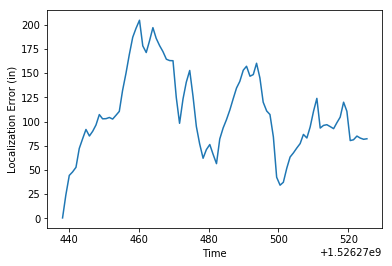

In [7]:
plt.plot(times, loc_errors)
plt.ylabel("Localization Error (in)")
plt.xlabel("Time")
plt.show()

In [8]:
np.mean(np.array(loc_errors))

108.24787341518866

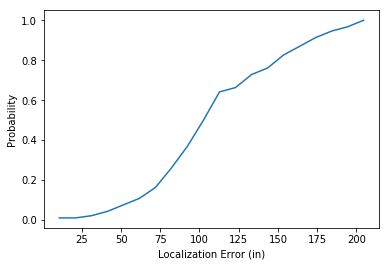

In [9]:
counts, bin_edges = np.histogram(loc_errors, bins=20, normed=True)
cdf = np.cumsum(counts)

plt.ylabel("Probability")
plt.xlabel("Localization Error (in)")
plt.plot(bin_edges[1:], cdf/cdf[-1])
plt.show()


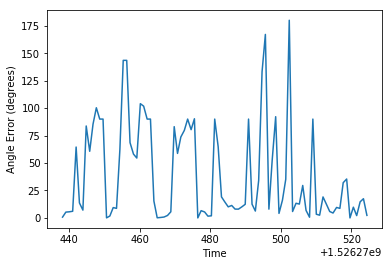

39.163735688928405


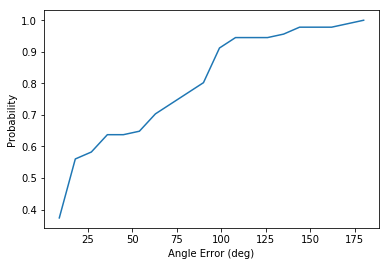

In [10]:
angle_errors, times = evaluation.evaluate_angle(loc, room.step_landmarks )
plt.plot(times, angle_errors)
plt.ylabel("Angle Error (degrees)")
plt.xlabel("Time")
plt.show()
print np.mean(angle_errors)

counts, bin_edges = np.histogram(angle_errors, bins=20, normed=True)
cdf = np.cumsum(counts)
plt.ylabel("Probability")
plt.xlabel("Angle Error (deg)")
plt.plot(bin_edges[1:], cdf/cdf[-1])
plt.show()
